# Machine Learning for Telecom with PCA-Kmeans

## Introduction

Machine Learning for Telecom with PCA-Kmeans is a notebook which domonstrates unsupervised learning with Spark ML on Call Detail Record(CDR) dataset.

In [1]:
%config IPCompleter.greedy=True

In [2]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from sagemaker import get_execution_role
import sagemaker_pyspark
import matplotlib.pyplot as plt
import numpy as np

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

In [3]:
cdr_start_loc = "<%CDRStartFile%>"
cdr_stop_loc = "<%CDRStopFile%>"
cdr_start_sample_loc = "<%CDRStartSampleFile%>"
cdr_stop_sample_loc = "<%CDRStopSampleFile%>"

df = spark.read.format("s3select").parquet(cdr_stop_sample_loc)
df.createOrReplaceTempView("cdr")

# Feature Extraction

In [4]:
dataDF = spark.sql("SELECT * from cdr where  _c0 = 'STOP'")
dataPd = dataDF.toPandas()
#Dropping Null Columns 
newPd = dataPd.dropna(axis=1)
newDataDF = spark.createDataFrame(newPd)

In [5]:
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(newDataDF) for column in list(set(newDataDF.columns)) ]

In [6]:
from pyspark.ml.feature import VectorAssembler
from array import array

inputcolsIndexer = []
for col in newDataDF.columns:
    inputcolsIndexer.append(col+"_index")
print(inputcolsIndexer)

vecAssembler = VectorAssembler(inputCols=inputcolsIndexer, outputCol="features")

['_c0_index', '_c1_index', '_c2_index', '_c3_index', '_c4_index', '_c5_index', '_c6_index', '_c7_index', '_c8_index', '_c9_index', '_c10_index', '_c11_index', '_c12_index', '_c13_index', '_c14_index', '_c15_index', '_c16_index', '_c17_index', '_c19_index', '_c20_index', '_c22_index', '_c24_index', '_c26_index', '_c27_index', '_c28_index', '_c29_index', '_c30_index', '_c31_index', '_c32_index', '_c33_index', '_c35_index', '_c37_index', '_c42_index', '_c45_index', '_c49_index', '_c50_index', '_c51_index', '_c52_index', '_c53_index', '_c54_index', '_c55_index', '_c58_index', '_c59_index', '_c60_index', '_c61_index', '_c63_index', '_c64_index', '_c65_index', '_c66_index', '_c67_index', '_c68_index', '_c69_index', '_c70_index', '_c73_index', '_c74_index', '_c77_index', '_c78_index', '_c79_index', '_c80_index', '_c81_index', '_c84_index', '_c90_index', '_c94_index', '_c101_index', '_c105_index', '_c106_index', '_c107_index', '_c108_index', '_c109_index', '_c110_index', '_c112_index', '_c113_

In [7]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

In [8]:
from pyspark.ml import Pipeline
stages = []
stages += indexers    
stages += [vecAssembler]
stages += [pca]

pipeline = Pipeline(stages=stages)
df_r = pipeline.fit(newDataDF).transform(newDataDF)

### Elbow Graph - Optimizes choice of k

In [9]:
import numpy as np 
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("pcaFeatures")
    model = kmeans.fit(df_r)
    cost[k] = model.computeCost(df_r) # requires Spark 2.0 or later

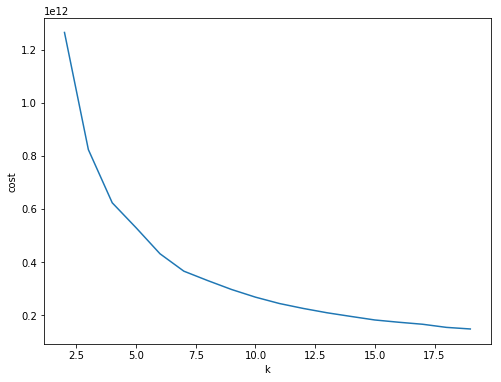

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

In [12]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=18, seed=1,featuresCol="pcaFeatures") 
model = kmeans.fit(df_r)

centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)
    

Cluster Centers: 
[-24595.69122445  18113.49016363]
[-5444.27214511  7819.52666392]
[-13856.11206146  -1333.03064195]
[-16351.99669853   3763.29882566]
[-8702.95070573  2468.37107938]
[-22134.31728998   -903.4682193 ]
[-27540.58560483   5558.65423744]
[-21301.00232942   5902.64468132]
[-17869.42637662  21430.46941155]
[-10159.17098621  20993.43140374]
[-11989.78596916   7900.06151776]
[-4189.74092118 14108.79174434]
[-19349.33526094  15231.55156155]
[-28268.96774193  12339.35927853]
[-14388.06861134  15181.82291572]
[-9699.88864578 13429.54114816]
[-16884.62847903   9918.88727593]
[-22748.59614553  11188.45300651]


In [13]:
s_data = df_r.sample(False,0.1)

In [14]:
transformed = model.transform(s_data)
pddf_predict = transformed.toPandas()

## Correlation matrix - HeatMap

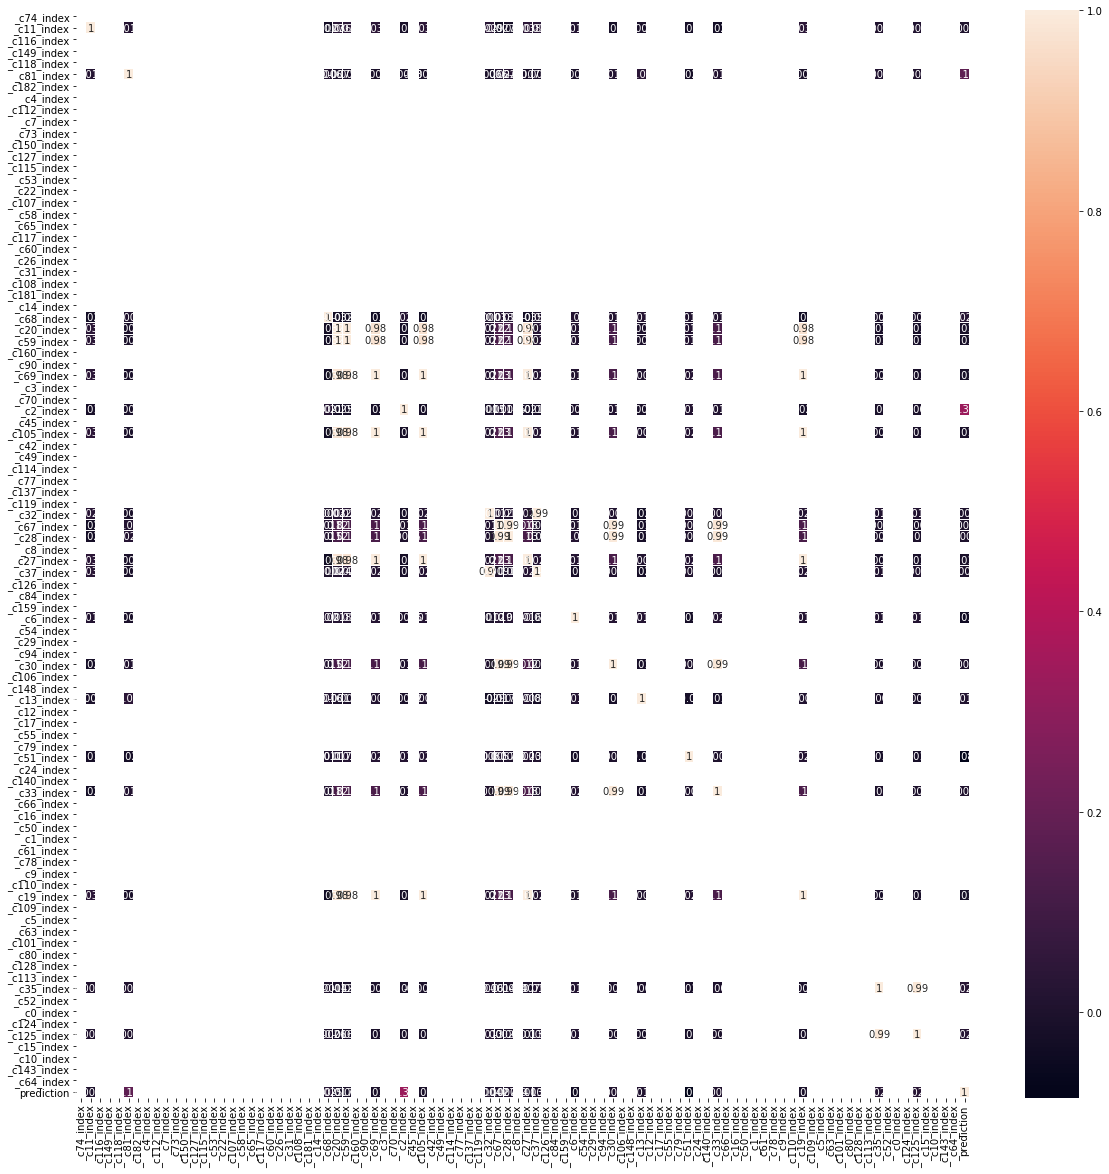

In [15]:
import seaborn as sns

# calculate the correlation matrix
corrPd = pddf_predict.dropna(axis=1)
# plot the heatmap
corr = corrPd.corr()

fig, ax = plt.subplots(figsize=(20,20))   
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True,linewidths=.1, ax=ax)

plt.show()

## Bernoulli Sampling dataset for Visualization

In [16]:
s_data = df_r
s_data.count()

22413

In [17]:
s_data = df_r.sample(False,0.1)
kmeans_s = KMeans(k=3, seed=1,featuresCol="pcaFeatures")  # 4 clusters here
model_s = kmeans_s.fit(s_data)

centers_s = model_s.clusterCenters()

print("Cluster Centers: ")
for center in centers_s:
    print(center)

Cluster Centers: 
[-13301.63830574  16572.7961319 ]
[-23202.49339815   9758.17279754]
[-12623.78407345   4502.38657002]


In [18]:
transformed_s = model_s.transform(s_data)
pddf_pred = transformed_s.toPandas()

# Visualization of Kmeans Cluster  - 3D 

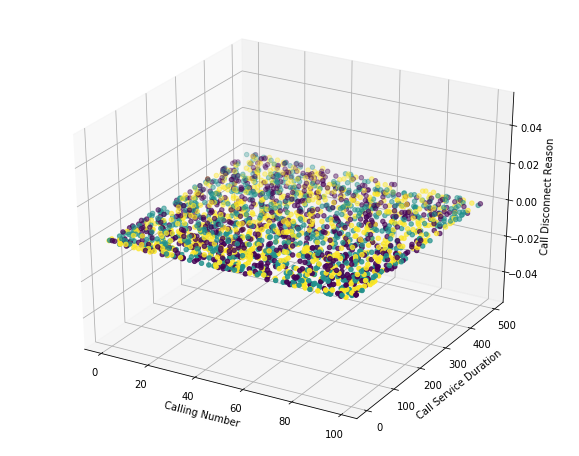

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# _c19_index - Calling Number
# _c13_index - Call Service Duration
# _c14_index - Call Disconnect Reason
threedee = plt.figure(figsize=(10,8)).gca(projection='3d')
threedee.scatter(pddf_pred._c19_index,pddf_pred._c13_index,pddf_pred._c14_index,c=pddf_pred.prediction)

threedee.set_xlabel('Calling Number')
threedee.set_ylabel('Call Service Duration')
threedee.set_zlabel('Call Disconnect Reason')
plt.show()


# Visualization of Kmeans Cluster - 2D 

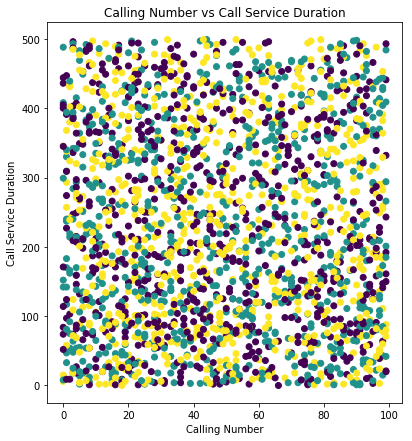

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# Set the size of the plot
plt.figure(figsize=(14,7))
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])
 
# Plot CDR
plt.subplot(1, 2, 1)
plt.scatter(pddf_pred._c19_index,pddf_pred._c13_index,c=pddf_pred.prediction)

# plt.title('Accounting Number vs Disconnect Reason')
# plt.xlabel('Accounting Number')
# plt.ylabel('Call Disconnect Reason')
plt.title('Calling Number vs Call Service Duration')
plt.xlabel('Calling Number')
plt.ylabel('Call Service Duration')
plt.show()


# Evaluation

In [21]:
def evaluation():
    from pyspark.ml.evaluation import ClusteringEvaluator
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(transformed_s)
    #silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

Silhouette with squared euclidean distance = 0.25198397125896277
Cluster Centers: 
[-24595.69122445  18113.49016363]
[-5444.27214511  7819.52666392]
[-13856.11206146  -1333.03064195]
[-16351.99669853   3763.29882566]
[-8702.95070573  2468.37107938]
[-22134.31728998   -903.4682193 ]
[-27540.58560483   5558.65423744]
[-21301.00232942   5902.64468132]
[-17869.42637662  21430.46941155]
[-10159.17098621  20993.43140374]
[-11989.78596916   7900.06151776]
[-4189.74092118 14108.79174434]
[-19349.33526094  15231.55156155]
[-28268.96774193  12339.35927853]
[-14388.06861134  15181.82291572]
[-9699.88864578 13429.54114816]
[-16884.62847903   9918.88727593]
[-22748.59614553  11188.45300651]


[[37. 24.]
 [57. 42.]
 [48. 14.]]


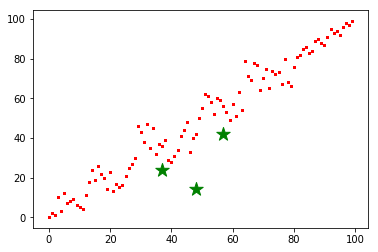

In [22]:
def plot_evaluation():
    # Getting the values and plotting it

    #_c19_index - Calling Number
    #_c20_index - Called Number
    f1 = pddf_pred._c19_index
    f2 = pddf_pred._c20_index

    # f1 = pddf_pred._c2_index
    # f2 = pddf_pred._c13_index

    X = np.array(list(zip(f1, f2)))
    plt.scatter(f1, f2, c='red', s=2)

    # Euclidean Distance Caculator
    def dist(a, b, ax=1):
        return np.linalg.norm(a - b, axis=ax)

    # Number of clusters
    k = 3
    # X coordinates of random centroids
    C_x = np.random.randint(0, np.max(X)-20, size=k)
    # Y coordinates of random centroids
    C_y = np.random.randint(0, np.max(X)-20, size=k)
    C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
    print(C)

    # Plotting along with the Centroids
    plt.scatter(f1, f2, c="red", s=2)

    plt.scatter(C_x, C_y, marker='*', s=200, c='g')
    
    
    from copy import deepcopy

    # To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
    # Cluster Lables(0, 1, 2)
    clusters = np.zeros(len(X))
    print(len(X))
    # Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old, None)
    # Loop will run till the error becomes zero
    while error != 0:
        # Assigning each value to its closest cluster
        for i in range(len(X)):
            distances = dist(X[i], C)
            cluster = np.argmin(distances)
            clusters[i] = cluster
        # Storing the old centroid values
        C_old = deepcopy(C)
        # Finding the new centroids by taking the average value
        for i in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == i]
            C[i] = np.mean(points, axis=0)
        error = dist(C, C_old, None)


    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    fig, ax = plt.subplots()
    for i in range(k):
            points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
            ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
    ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')

# Centroids 

In [ ]:
spark_version = spark.version
print(spark_version)
if spark_version >= '2.3.0':
    evaluation()
    plot_evaluation()